[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/05_Coding_Logistic_Regression.ipynb)

*Note: GitHub.com does not render everything when viewing these notbeook files, so click the "Open in Colab" button above to see everything as it's intended.*

# Lesson: Coding (Binary) Classification, i.e. Logistic Regression

## First: JavaScript Demo (1D Data)
Read through the "[🎅 Naughty by Numbers:
Classifications at Christmas](https://hedges.belmont.edu/naughty/)" explorable JavaScript Demo.  You can skip the Appendix, but read everything else and "play" with the buttons/ run the demo.

<a href="https://hedges.belmont.edu/naughty/"><img alt="image of naughty by numbers demo" src="https://hedges.belmont.edu/naughty/naughty2.png"></a>

### Supplementary Intro Materials (2D Data, Optional)
* Andrej Karpathy made an excellent [Javascript Demo for 2D data](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html).
* SciKit-Learn has a great [comparison of different methods of classification](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html): ![scikit classifier comparison image](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

## Second: Let's Make Some Data


### 3D Data from Iris Flowers
We'll start with the [Iris Flowers Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) which conveniently is used for demos of [3D Scatter Plots in Plotly](https://plotly.com/python/3d-scatter-plots/).

In [ ]:
# if you're on Kaggle, uncomment and run the next line. Not needed on Colab
#!pip install plotly matplotlib numpy pandas

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm   # combines an iterator and a progress bar

In [ ]:
df = px.data.iris()  # pandas dataframe
df = df.loc[df['species'].isin(['virginica', 'versicolor'])] # grab just two of the species
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.show()

This happens to be a very easy dataset for which one input feature alone -- in this case "petal width" -- is sufficient for classification.  But, we'll use it for now, and can add other datasets in a bit.

Let's convert our Pandas dataframe into a numpy array that we can do calculations on.

Actually, we will have two arrays: one for the inputs which we'll call "X", and one for the target labels which we'll call "Y".  These labels will be one-hot encoded with zero's and 1's. Let's make Y first.  Let's take a look at `df`:

In [ ]:
df

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
50,7.0,3.2,4.7,1.4,versicolor,2
51,6.4,3.2,4.5,1.5,versicolor,2
52,6.9,3.1,4.9,1.5,versicolor,2
53,5.5,2.3,4.0,1.3,versicolor,2
54,6.5,2.8,4.6,1.5,versicolor,2
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,3
146,6.3,2.5,5.0,1.9,virginica,3
147,6.5,3.0,5.2,2.0,virginica,3
148,6.2,3.4,5.4,2.3,virginica,3


Let's take the `species_id` column and subtract 2 from it to make it zeros and 1's.  And we'll add a couple text labels to distinguish which is which. We *could* just hard-code the labels manually, by writing, say,...

In [ ]:
labels = ['versicolor','virginica']

...and that would be fine.  However, I like the idea of something that will work more generally, so lets grab the unique labels from `df`, while preserving their order:

In [ ]:
labels = list(dict.fromkeys(list(df['species'])))
labels

['versicolor', 'virginica']

In [ ]:
labels[0]

'versicolor'

In [ ]:
Y = df['species_id'].to_numpy()-2
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Now let's make a numpy array for the input features X, using the columns of the Pandas Dataframe that were used for the plot above.

In [ ]:
X = df[['petal_width','sepal_width','sepal_length']].to_numpy()
X[0:10]

array([[1.4, 3.2, 7. ],
       [1.5, 3.2, 6.4],
       [1.5, 3.1, 6.9],
       [1.3, 2.3, 5.5],
       [1.5, 2.8, 6.5],
       [1.3, 2.8, 5.7],
       [1.6, 3.3, 6.3],
       [1. , 2.4, 4.9],
       [1.3, 2.9, 6.6],
       [1.4, 2.7, 5.2]])

Now the idea will be, given an a point in the space of X (i.e. the [`petal_width'`,`sepal_width`,`sepal_length`] space), can we train a model to predict which flower that point "should" correspond to?  

...using logistic regression and gradient descent?  

## Coding up the Solver

First we a function for the logistic sigmoid and its gradient, i.e. its derivatives with respect to the variables which will describe the"width" (or "steepness") and "center point" of the s-shaped function we will fit to our data.

The sigmoid itself is...

In [ ]:
def sigmoid(q):
    return 1/(1+np.exp(-q))

...where `q` can be parameterized via a linear combination of inputs $x, y,$ and $z$, (corresponding to our 3 input features about the flowers), and "weights"
$a, b,$ and $c$ as well as a constant offset or "bias" value $d$:
$$q = ax + by + cz + d$$

We could just as easily -- and we might as well -- name these weights $w_i$ where $i$ runs from 0 to 3. Then (rearranging the "$d$" term)...
$$ q = w_0 + w_1 x + w_2 y + w_3 z$$

Or even more abstractly we let $x, y$ and $z$ be parts of the overall input $X$ as $X_1, X_2,$ and $X_3$, and the we can make an additional $X_0 = 1$ to do with the bias term ($d$ / $w_0$).  Then
$$q = \sum_{i=0}^3 w_i X_i$$
provided that we add a column of 1's on the "left" side of our `X` variable:

In [ ]:
ones = np.ones(X.shape[0])[:,np.newaxis]
ones.shape

(100, 1)

In [ ]:
X.shape

(100, 3)

In [ ]:
X2 = np.hstack([ones, X])
print(X2[0:5]) # let's look at the first several rows
X = X2 # update X to have 4 columns

[[1.  1.4 3.2 7. ]
 [1.  1.5 3.2 6.4]
 [1.  1.5 3.1 6.9]
 [1.  1.3 2.3 5.5]
 [1.  1.5 2.8 6.5]]


So we're almost done...setting up the data, and being ready to write our our weights -- we're only going to have four numbers, which we'll initialize randomly to start with:

In [ ]:
np.random.seed(5) # set some seed value for reproducability
w = 2*np.random.rand(X.shape[-1])-1   # 4 random numbers, between -1 and 1
w

array([-0.55601366,  0.74146461, -0.58656169,  0.83722182])

These are our initial guesses for weights, which we will progressive refine via gradient descent.

## Splitting the Dataset into Train & Validation Subsets
When we train our model, we'd like to have a measure of how it's doing on data we've never seen before.  How many data points are there in total?

In [ ]:
X.shape[0] # number of rows = number of points

100

100 points is often not enough for sophisticated neural networks applications, but in this case it will be fine.  

What we need to do is randomly shuffle *both* X *and* Y together at the same time.   (We could have done this up near the top when the data was in Dataframe form, but we can do it here).  One way is to shuffle an array of indices:

In [ ]:
indices = np.arange(X.shape[0])
indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

Shuffle those:

In [ ]:
np.random.shuffle(indices)
indices

array([84, 10, 20, 23, 63, 54, 42, 56, 28, 66, 68, 71, 73,  6, 40, 17, 59,
       50, 79, 99, 48, 39, 22, 35, 46, 74, 85, 92, 86, 37, 49, 12, 32, 90,
       13, 24, 34, 93, 61, 67, 81, 69, 26, 52, 60, 87, 64, 21, 25, 33, 29,
       91, 14, 70, 57, 55, 78,  3, 43, 11, 83, 45, 88, 72, 94, 82, 19, 38,
        2, 31, 89, 51, 36,  4,  0, 58,  5, 16,  1, 98, 41,  9, 18, 96, 47,
       65, 75, 77, 44, 97, 95, 53, 15, 76,  7, 80, 30, 27, 62,  8])

Now we can take subsets of X and Y where we address them using the shuffled indices.

In [ ]:
split_ind = int(0.8*len(indices))
indices_train, indices_val = indices[:split_ind], indices[split_ind:]
X_train, Y_train = X[indices_train,:], Y[indices_train]
X_val, Y_val = X[indices_val,:], Y[indices_val]

In [ ]:
print("X_train.shape, Y_train.shape = ",X_train.shape, Y_train.shape)
print("X_val.shape, Y_val.shape = ",X_val.shape, Y_val.shape)

X_train.shape, Y_train.shape =  (80, 4) (80,)
X_val.shape, Y_val.shape =  (20, 4) (20,)


Let's put all of this into a subroutine we can call again later:

In [ ]:
def train_val_split(X, Y, split_pct=0.8):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_ind = int(split_pct*len(indices))
    indices_train, indices_val = indices[:split_ind], indices[split_ind:]
    X_train, Y_train = X[indices_train,:], Y[indices_train]
    X_val, Y_val = X[indices_val,:], Y[indices_val]
    return X_train, Y_train, X_val, Y_val

Now our data is set up so we can train on a subset and monitor the "learning" using the other subset. We will monitor using the loss function -- i.e. the "Binary Cross-Entropy" (BCE) loss:

In [ ]:
def loss_bce(
    preds,    # predictions,  output from sigmoid function ( 0 < pred < 1 )
    targs     # target label numbers, 0 or 1
    ):
    "BCE Loss"
    return -( targs*np.log(preds) + (1-targs)*np.log(1-preds) ).mean()

Let's make a picture of what that looks like

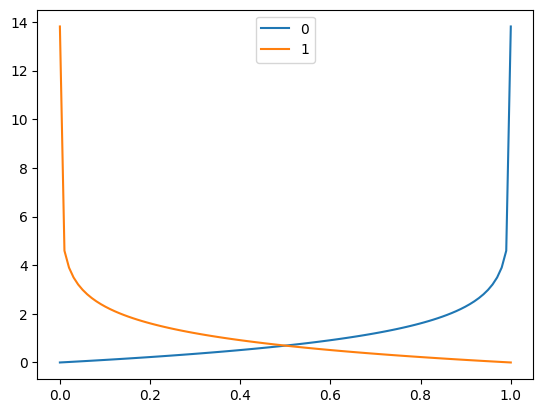

In [ ]:
preds = np.linspace(1e-6, 1-1e-6, num=100)
for targ_val in [0,1]:
    targs = targ_val * np.ones(len(preds))
    losses = -( targs*np.log(preds) + (1-targs)*np.log(1-preds) )
    plt.plot(preds, losses, label=str(targ_val))
plt.legend()

The shapes of these curves look a little "weird", but note that we don't actually use these in training.  Recall that the gradient of the BCE is the trivial "line"

$$\tag{5} L^\prime_{\rm BCE}  = {\partial L_{\rm BCE} \over \partial q}  =  {\partial L_{\rm BCE} \over \partial \hat{Y_i}} {\partial \hat{Y}_i\over \partial q}  = {1\over N}\sum_i (\hat{Y_i}- Y_i).$$

...where $\hat{Y}_i$ is the output of our sigmoid function, and $(\hat{Y}_i - Y_i)$ means the same as `(preds-targs`) in our code.

That's a derivative with respect to q, and q is a linear function of the weights, and by the Chain rule, the derivative of the loss with respect to the weights is just the product of the above derivative and each input, i.e.

$$
{\partial L_{\rm BCE}\over \partial w_j }  = {\partial L_{\rm BCE} \over \partial \hat{Y_i}} {\partial \hat{Y}_i\over \partial q}  {\partial q \over \partial w_j} =  {1\over N}\sum_i (\hat{Y_i}- Y_i) X_{ij}    
$$
and for gradient *descent* we'll take a step in the negative ^^ that 👆 direction.

> **NOTE:** In "$X_{ij}$", $i$ is the row number (for each data point) and $j$ is the column number (for each input feature).

So we need to multiply the weights by the input features and sum them up. There are two equivalent ways we can do this:

In [ ]:
q = (w * X_train).sum(axis=1)

In [ ]:
q2 = np.dot(X_train, w)  # dot product is elementwise multiplication followed by sum

Check that these are equivalent

In [ ]:
assert np.allclose( q, q2 )   # allclose compares arrays of floats to within some tolerance

...no news is good news.  Our model predictions are the sigmoid applied to q:

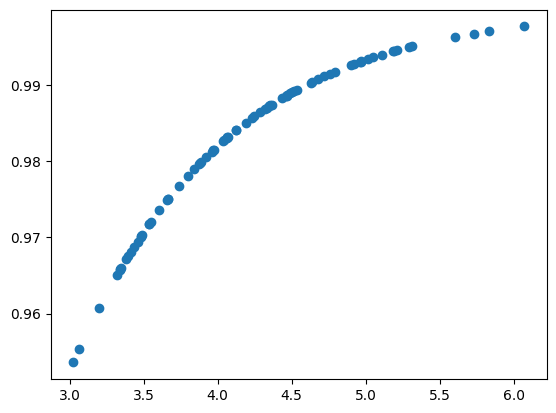

In [ ]:
preds = sigmoid(q)
plt.plot(q, preds, 'o')   # let's look at our initial guesses, which are probably way off

Currently our predictions, rather than having a mix of near-1's and near-0's, we get mostly near-1's.  

But we haven't bothered to train the weights yet.  We'll do that shortly.  Let's make sure that we can get gradients for the 4 weight values:

In [ ]:
# oh, first let's be explicit that "targs" is the same thing as Y_train, for what follows
targs = Y_train

To get our weights, need to multiply those by each input feature, and take the mean.  If we just write that naively, it won't work because the array dimensions won't work out.  The following line would fail:

```Python
grads = ((preds-targs)*X_train).mean()
```
with the error message
```Python
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-26-60eeb174e20a> in <module>
----> 1 grads = ((preds-targs)*X_train).mean()

ValueError: operands could not be broadcast together with shapes (80,) (80,4)
```

The error is because the "last dimension" of each array needs to match up.

Instead, we can take the transpose of `X_train` so it has dimensions `(4, 80)`, then it can work.  Then we need to take `mean(axis=1)` instead of just `mean()` (for which the default is `axis=0`):

In [ ]:
grads = ((preds-targs)*X_train.T).mean(axis=1)
grads

array([0.48260374, 0.63550903, 1.34151534, 2.86106646])

Yea!  Now we're ready!  Now YOU'RE ready. You're going to write the parts, and then you're going to train the model.

In [ ]:
# GRADED EXERCISE 1
def compute_q(w, X):
    q = # your code here
    return q

SyntaxError: invalid syntax (1046877002.py, line 3)

In [ ]:
# test code for compute_q
np.random.seed(2)
n, f = 2, 5
wt, Xt = (np.random.rand(f)-0.5)/10, np.random.random((n,f))
yours = compute_q(wt, Xt)
mine = np.array([-0.01280361, -0.03318289])
assert np.allclose( yours, mine ), f"Test failed. yours = {yours}"
print("Test passed!")

In [ ]:
# GRADED EXERCISE 2
def compute_preds(q):
    preds =  # your code here
    return preds

In [ ]:
# DO NOT MODIFY THIS CELL
# test code for compute_preds
tol = 1e-8
assert np.abs( compute_preds(-1) - 0.2689414213699951) < tol
assert np.abs( compute_preds(0) - 0.5) < tol
assert np.abs( compute_preds(5) - 0.9933071490757153) < tol
print("Test passed!")

In [ ]:
# GRADED EXERCISE 3
def compute_grads(preds, targs, X):
    grads =  # your code here
    return grads

In [ ]:
# DO NOT MODIFY THIS CELL
# test for compute_grads
np.random.seed(0)
preds_t, Yt = np.random.random(n), np.random.randint(0,high=2,size=n)
yours = compute_grads(preds_t, Yt, Xt)
mine = np.array([-0.16297407, -0.12152   , -0.15886825, -0.14073633, -0.08645965])
assert np.allclose( yours, mine ), f"Test failed. yours = {yours}"
print("Test passed!")

# Updating the weights
To update each weight(s), we change their value(s) by subtracting from their previous value, the gradient(s) times the learning rate, i.e.

$$ w_j := w_j -   \alpha  {\partial L_{BCE}\over \partial w_j}$$
where the minus sign is to perform gradient *de*scent.  

Or in terms of our code, we'll be using "`w`" to denote all the weights (so all the $w_j$'s will be included), and "`lr`" for the learning rate, and `"grads`" for the gradients.

In [ ]:
# GRADED EXERCISE 4
def update_w(w, grads, lr):
    w =  # your code here
    return w

In [ ]:
# DO NOT MODIFY THIS CELL
# test for update_w
np.random.seed(0)
lr_t, grads_t = 0.1, np.random.rand(len(wt))
yours = update_w(wt, grads_t, lr_t)
mine = np.array([-0.06128186, -0.11892631, -0.05531009, -0.06095608, -0.0503287 ])
assert np.allclose( yours, mine ), f"Test failed. yours = {yours}"
print("Test passed!")

In [ ]:
# GRADED EXERCISE 5
def pred_and_update_step(w, X_train, Y_train, lr):
    ### YOUR CODE HERE
    q = # call compute_q
    preds_train = # call compute_preds
    grads = # call compute_grads
    w = # call update_w
    ### END of YOUR CODE
    return w

In [ ]:
# DO NOT MODIFY THIS CELL
# test for pred_and_update_step
yours = pred_and_update_step(wt, Xt, Yt, lr_t)
mine = np.array([ 0.01769669, -0.0288104 ,  0.02396745,  0.01412402,  0.00343766])
assert np.allclose( yours, mine ), f"Test failed. yours = {yours}"
print("Test passed!")

## Train the Model

In [ ]:
def run_training(X_train, Y_train, X_val, Y_val,
    training_steps=500,    # number of training steps to run
    lr=0.2,                 # learning rate  ;  step size = lr * gradient * lr
    ):
    np.random.seed(5) # set some seed value for reproducability
    w = 2*np.random.rand(X.shape[-1])-1   # 4 random numbers, between -1 and 1
    loss_hist_train, loss_hist_val, acc_hist = [], [], [] # store histories for plotting
    with tqdm(range(training_steps)) as t:
        for step in t:
            w = pred_and_update_step(w, X_train, Y_train, lr)

            # monitoring: check performance using validation set
            q_val      = compute_q(w, X_val)
            preds_val  = compute_preds(q_val)
            loss_val   = loss_bce( preds_val, Y_val)
            loss_train = loss_bce( compute_preds(compute_q(w,X_train)), Y_train)  # used only for monitoring
            acc = np.sum(np.round(preds_val) == Y_val)/len(Y_val) * 100    # accuracy measurement for val set
            t.set_description(f"step {step}: loss_train = {loss_train:.3f}, loss_val = {loss_val:.3f}. Acc = {acc}%")
            loss_hist_train.append(loss_train),  loss_hist_val.append(loss_val), acc_hist.append(acc)  # save values for plotting later

    return w, loss_hist_train, loss_hist_val, acc_hist


w, loss_hist_train, loss_hist_val, acc_hist = run_training(X_train, Y_train, X_val, Y_val)

# plot loss histories
plt.semilogy(loss_hist_train, label='train')
plt.semilogy(loss_hist_val, label='val')
plt.xlabel('step'), plt.ylabel('loss (log scale)')
plt.legend()
plt.show()

plt.plot(acc_hist, label='val')
plt.xlabel('step'), plt.ylabel('Accuracy %')
plt.legend()
plt.show()

Let's take a look at our predictions on the Validation set:

In [ ]:
preds_val = compute_preds(compute_q(w, X_val))
plt.plot(np.round(preds_val),'o-')
plt.plot(Y_val,'o')
print("any exposed blue dots not covered by orange dots show inaccurate predictions")

Lets visualize the results in the 3D input space

In [ ]:
XY_train = np.hstack([X_train[:,1:],Y_train[:,np.newaxis]]) # rip out the 1's from X, add axis to Y
XY_val = np.hstack([X_val[:,1:],Y_val[:,np.newaxis]])
columns = ['sepal_length','sepal_width','petal_width','species']
df_train = pd.DataFrame(XY_train, columns=columns)
df_val = pd.DataFrame(XY_val, columns=columns)
fig = px.scatter_3d(df_train, x='sepal_length', y='sepal_width', z='petal_width', color='species') # , size=7*np.ones(len(df)))


iso= True
if iso:
    x, y, z = XY_train[:,0], XY_train[:,1], XY_train[:,2]

    # make a 3d mesh of coordinate values to run predictions on
    XX, YY, ZZ = np.mgrid[x.min():x.max():40j, y.min():y.max():40j, z.min():z.max():40j]
    DD = np.ones(XX.shape)
    qq = w[0]*DD + w[1]*XX + w[2]*YY + w[3]*ZZ  # perform the module prediction "manually"
    preds_3d = sigmoid(qq)

    fig.add_trace(go.Isosurface(       # show values near "0.5" decision boundary
        x=XX.flatten(), y=YY.flatten(), z=ZZ.flatten(), value=preds_3d.flatten(),
        isomin=0.47,  isomax=0.53, showscale=False, colorscale='Viridis'))
    fig.add_trace(go.Isosurface(  # see-through volume colored with pred value
        x=XX.flatten(), y=YY.flatten(), z=ZZ.flatten(), value=preds_3d.flatten(),
        isomin=0,  isomax=1,  opacity=0.25, showscale=False, colorscale='Viridis' ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))  # tight layout
fig.show()

## New Data: Inner & Outer Spheres
The previous dataset was too easy!

Let's make a new dataset that's a bit harder, and see how our model performs: We'll make a 3D "ball" of data, and separate it into two classes based on some value of the radius.

In [ ]:
np.random.seed(0)
npoints = 400
xs = 2*np.random.rand(npoints) - 1
ys = 2*np.random.rand(npoints) - 1
zs = 2*np.random.rand(npoints) - 1
X = np.vstack([np.ones(npoints), xs,ys,zs]).T
X.shape

We'll set up the target values to correspond to points inside and outside a radius value we specify:

In [ ]:
radius = 1
Y = ((X[:,1]**2 + X[:,2]**2 + X[:,3]**2) > radius).astype(np.int16)

# let's take a look at a few values:
n = 6
print(X[0:n,:],'\n', Y[0:n])
print("Percentage of non-zero targets = ",Y.mean()*100,"%")

In [ ]:
fig = go.Figure(data=[go.Scatter3d( x=X[:,1], y=X[:,2], z=X[:,3],
    mode='markers', marker=dict(color=Y, size=7))])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))  # tight layout
fig.show()

In [ ]:
X_train, Y_train, X_val, Y_val = train_val_split(X, Y)
X_train.shape

Now run the training script:

In [ ]:
w, loss_hist_train, loss_hist_val, acc_hist = run_training(X_train, Y_train, X_val, Y_val, training_steps=1000, lr=0.1)

In [ ]:
# plot loss histories
plt.semilogy(loss_hist_train, label='train')
plt.semilogy(loss_hist_val, label='val')
plt.xlabel('step'), plt.ylabel('loss (log scale)')
plt.legend()
plt.show()

plt.plot(acc_hist, label='val')
plt.xlabel('step'), plt.ylabel('Accuracy %')
plt.legend()
plt.show()

Yikes.  Our model never did better than randomly flipping a coin! What's wrong?  Let's take a look at the data and the predictions...

In [ ]:
XY_train = np.hstack([X_train[:,1:],Y_train[:,np.newaxis]]) # rip out the 1's from X, add axis to Y
XY_val = np.hstack([X_val[:,1:],Y_val[:,np.newaxis]])
XY_all = np.vstack([XY_train, XY_val])
columns = ['x','y','z','class']
df_all = pd.DataFrame(XY_all, columns=columns)
fig = px.scatter_3d(df_all, x=columns[0], y=columns[1], z=columns[2], color=columns[3]) # , size=7*np.ones(len(df)))

iso= True  # if we want "isosurfaces" to go with the scatter plot
if iso:
    x, y, z = XY_train[:,0], XY_train[:,1], XY_train[:,2]

    # make a 3d mesh of coordinate values to run predictions on
    XX, YY, ZZ = np.mgrid[x.min():x.max():40j, y.min():y.max():40j, z.min():z.max():40j]
    DD = np.ones(XX.shape)
    qq = w[0]*DD + w[1]*XX + w[2]*YY + w[3]*ZZ  # perform the module prediction "manually"
    preds_3d = sigmoid(qq)

    fig.add_trace(go.Isosurface(       # show values near "0.5" decision boundary
        x=XX.flatten(), y=YY.flatten(), z=ZZ.flatten(), value=preds_3d.flatten(),
        isomin=0.499,  isomax=0.501, showscale=False, colorscale='Viridis'))
    fig.add_trace(go.Isosurface(  # see-through volume colored with pred value
        x=XX.flatten(), y=YY.flatten(), z=ZZ.flatten(), value=preds_3d.flatten(),
        isomin=0,  isomax=1,  opacity=0.25, showscale=False, colorscale='Viridis' ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))  # tight layout
fig.show()

Oh, no!  What's wrong with our method?



## Limitations of Logistic Regression Alone

It's because, despite the nonlinearity of the sigmoid -- which is only used to fit the target values -- the "q" feeding into is still only a *linear combination* of the input features.  Thus we can *only fit planes* as our decision boundaries.

How can we allow for more complicated decision boundaries?  Put differently, how might we re-map the space of points into something that would admit a planar decision boundary?

In the present case, one could do "feature engineering" by computing the radius manually, and feeding that into logistic regression.  This is a common task for many data scientists.

## Extra/Ungraded Exercise 1
Do this yourself: Compute the radius, as use this as *a single* input feature, and perform logistic regression on that.

## Next Time: Automatic Feature Engineering via Neural Networks
What if there were a way to compute (an approximation to) the radius automatically?  There is in fact a way, and neural networks often perform very well at doing automatic feature engineering.

In our next lesson, we'll add some neuron layers "before" the logistic regression output.  Propagating all the gradients through multiple layers will prove cumbersome to write out by hand, so we'll let PyTorch handle that for us.